# Second order BVP

This section is concerned with the solution of a general class of second order ODE, in which we are given a value for the function on two boundaries.

\begin{equation*}
y^{\prime\prime}=f(y(x),y^{\prime}(x),x), \qquad y(a)=\alpha, \quad y(b)=\beta.
\end{equation*}

Boundary value problems are generally more tricky than initial value problems. In 1D problems the problem can be solved by setting up a matrix system of equations for each node. This approach can be generalised to higher dimensions, but it becomes challenging to implement.

In this chapter we will also demonstrate an iterative **relaxation** approach that we will be able to generalise to higher dimensions.

(dirode)=
## Example

By way of example, we will solve the second order linear ODE that we considered in {numref}`cauchy_example`, this time using Dirichlet-type boundary conditions at $x=0,1$.

```{math}
:label: 2order_dir
\frac{\mathrm{d}^2 y}{\mathrm{d}x^2} + \frac{\mathrm{d}y}{\mathrm{d}x}-6 y = 0, \qquad y(0)=1, \quad y(1)=2.
```

Notice that it is not possible to use the forward-stepping solution technique that we saw in the last chapter, because we do not have a derivative condition that we can use on the left boundary to find gridpoint $y_1$. We could simply "guess" this value and then apply the update rule {eq}`example_upd` as illustrated below. Comparison of $u_n$ to the right-hand boundary value would provide information about how good our guess was.

<br>

```{image} images/shooting_idea.png
:alt: secant
:align: center
:scale: 80%
```
<br>

The guess can be repeatedly modified using a root-finding technique to obtain a value which works. This clever technique is called a **shooting method**. It is fairly straightforward to implement and you may wish to give it a try. However, it does not generalise well to solve PDE problems, so we will use other methods.

We could use the matrix technique that we introduced in {numref}`matrix-cauchy`. Here, there is no need to introduce a fictitious node. The boundary conditions can be implemented in the first and last rows and we obtain the following matrix system to solve.

```{math}
:label: dirmatr1
\left[\begin{array}{cccccc}
1 &0 & 0 & 0 & \dots & 0\\
1-h/2 & -(2+6h^2) & 1+h/2 & 0 & \ddots &\vdots\\
0 & 1-h/2 & -(2+6h^2) & 1+h/2 & \ddots&\vdots\\
\vdots& \ddots & \ddots &\ddots &\ddots & 0\\
0 & \ddots & 0& 1-h/2 & -(2+6h^2) & 1+h/2\\
0 &\dots & 0 & 0 & 0 & 1\end{array}\right]
\left[\begin{array}{cc} y_0\phantom{\vdots}&\\y_1&\phantom{\vdots}\\y_2\phantom{\vdots}&\\ \vdots&\\y_{N-1}\\y_N\end{array}\right]=\left[\begin{array}{cc}1&\phantom{\vdots}\\0&\phantom{\vdots}\\0&\phantom{\vdots}\\\vdots&\\0\\2\end{array}\right]
```

The result obtained by numerically solving this system is shown below.

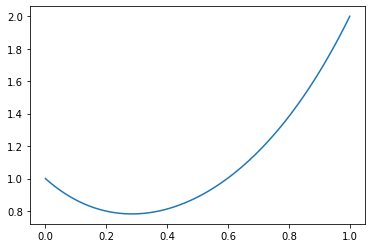

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the nodes
n=100                    # solving with 100 nodes
x=np.linspace(0,1,n)   # on the domain [0,1]
h = x[1]-x[0]          # size of each interval
#---------------------------------------------------------------
# Construct tridiagonal matrix A and vector b
# Initially we do not worry about implementation of the BCs

coeff1 = 1-h/2
coeff2 = -2-6*h**2
coeff3 = 1+h/2

A = np.diag(coeff1*np.ones(n-1),k=-1) + \
    np.diag(coeff2*np.ones(n),  k=0) + \
    np.diag(coeff3*np.ones(n-1),k=1)

b = np.zeros((n,1))   # the problem was homogeneous

#---------------------------------------------------------------
# Enforce the boundary conditions

A[0,[0,1,2]] = [1,0,0]
b[0]=1

#y_0=1:
A[-1, [-3,-2,-1]] = [0,0,1]
b[-1] = 2

#---------------------------------------------------------------

# Solve the matrix system numerically
y,_,_,_= np.linalg.lstsq(A,b,rcond = None)

plt.plot(x,y)
plt.show()

```{exercise}
Apply the matrix solution approach to solve the 1D heat equation using a central finite difference scheme
\begin{equation*}
u^{\prime\prime}(x)=\sin(2\pi x), \qquad u(x_1)=0, \quad u(x_n)=0
\end{equation*}
```

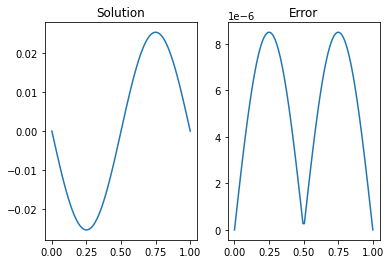

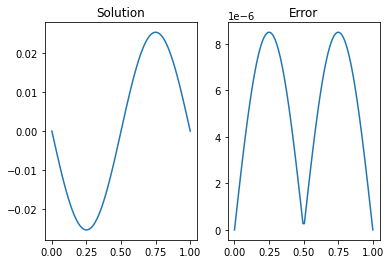

In [2]:
from myst_nb import glue
import numpy as np
import matplotlib.pyplot as plt

# The initial setup is the same as before
n=100
x = np.linspace(0,1,n)
h = x[1]-x[0]   

# Create a lambda function for f
f= lambda x: np.sin(2*np.pi*x);

# Construct coefficient matrices :

from scipy.sparse import spdiags
import numpy.matlib as ml
A = np.transpose(ml.repmat([1,-2,1],n,1))
diags = np.array([-1, 0, 1])
A = spdiags(A, diags, n, n).toarray()
A[0,[0,1]]=[1,0]
A[-1,[-2,-1]]=[0,1]

F = f(x)
F[0]=0
F[-1]=0;

#Solve by Gaussian elimination for U
U,_,_,_= np.linalg.lstsq(A,h**2*F,rcond = None)

# Plot and compare to the analytic solution
sol = -np.sin(2*np.pi*x)/4/np.pi**2;

fig,ax = plt.subplots(1,2)
ax[0].plot(x,U)
ax[0].set_title('Solution')
ax[1].plot(x,abs((U.T-sol).T))
ax[1].set_title('Error')

glue("1dheat_fig", fig, display=False)

````{toggle}

**Solution:**
The central difference formula gives

\begin{equation*}
u_{k+1}-2u_k+u_{k-1}=h^2\sin(2\pi x_k)
\end{equation*}

With the boundary conditions included, we obtain the system below, where $f(x)=\sin(2\pi x)$.

\begin{equation*}
\left[\begin{matrix}
1 & 0 & 0 & \dots & \dots & 0 & 0\\
1 & -2 & 1 &&\dots & 0\\
0&1&-2&1\
\vdots&&\ddots&\ddots&\ddots&&\vdots\\
&&&&1&-2&1&0\\]0&\dots &&&1&-2&1\\
0&0&\dots&\dots&0&0&1
\end{matrix}\right]
\left[\begin{matrix}u_1\\u_2\\u_3\\\vdots\\u_{N-2}\\u_{N-1}\\u_N\end{matrix}\right]
=h^2\left[\begin{matrix}0\\f(x_2)\\f(x_3)\\\vdots\\f(x_{N-2})\\f(x_{N-1})\\0\end{matrix}\right]
\end{equation*}

The following code can be used to produce the solution:

```python
# The initial setup is the same as before
n=100
x = np.linspace(0,1,n)
h = x[1]-x[0]   

# Create a lambda function for f
f= lambda x: np.sin(2*np.pi*x);

# Construct coefficient matrices :
from scipy.sparse import spdiags
import numpy.matlib as ml
A = np.transpose(ml.repmat([1,-2,1],n,1))
diags = np.array([-1, 0, 1])
A = spdiags(A, diags, n, n).toarray()
A[0,[0,1]]=[1,0]
A[-1,[-2,-1]]=[0,1]

F = f(x)
F[0]=0
F[-1]=0;

#Solve by Gaussian elimination for U
U,_,_,_= np.linalg.lstsq(A,h**2*F,rcond = None)

# Plot and compare to the analytic solution
sol = -np.sin(2*np.pi*x)/4/np.pi**2;
fig,ax = plt.subplots(1,2)
ax[0].plot(x,U)
ax[0].set_title('Solution')
ax[1].plot(x,abs((U.T-sol).T))
ax[1].set_title('Error')
plt.show()
```

```{glue:} 1dheat_fig
```
````

## Fixed point method

As an alternative to using the simultaneous system of equations, the solution can often be found iteratively, by starting with a suitable initial guess for the whole field $u$ and applying the formulas until (hopefully!) a fixed solution is determined.

To demonstrate, we will return to the 1d heat problem that was given as an exercise in the previous section

\begin{equation}u^{\prime\prime}(x)=\sin(2\pi x), \qquad u(0)=0, \quad u(1)=0\end{equation}

We again apply the central finite difference scheme, but this time we rearrange to the form $u=F(u)$.

```{math}
:label: itsolver
u_k=\frac{u_{k+1}+u_{k-1}}{2}-\frac{h^2}{2}\sin(2\pi x_k)
```

We will repeatedly apply this equation until $u$ converges to a result. A schematic illustration of this idea is provided below.

<br>

```{image} images/fixed_point.png
:alt: secant
:align: center
:scale: 70%
```
<br>

There are a few slightly different ways that the iterative steps can be performed, which are discussed in the subsections below.

### Jacobi iteration
In Jacobi iteration, each iterative step uses only values from the "old" array. We take our starting guess for $u$ and apply it as a static input to the RHS of equation {eq}`itsolver` to obtain our new result for $u$. We repeat the method with our new result as the starting guess.

A visualisation of how the technique applies to {eq}`itsolver` is shown below.

<br>

```{image} images/jacobi.png
:alt: secant
:align: center
:scale: 70%
```
<br>

The following code applies a single Jacobi iteration for this problem. Input $k$ should contain the values of $\frac{h^2}{2}\sin(2\pi x)$.

In [3]:
def jac(u0,k):
    # Jacobi Iteration
    u1=np.hstack((u0[0],(u0[2:]+u0[0:-2]-k[1:-1])/2,u0[-1]))
    return u1

To find the fixed points of the Jacobi iteration, we may use a function like the one below.
Here, `testfun` will be the Jacobi iteration and `u0` will be the initial guess. The parameter `accgoal` sets a value for the desired level of convergence to achieve, and `maxit` is used to limit on the maximum number of iterations to be tried before giving up.

In [4]:
def iterate(testfun, u0, maxit, accgoal):
    # Iterate until converged to within specified accuracy
    for counter in range(int(maxit)):
        u1 = testfun(u0)
        err = np.linalg.norm(u1-u0)
        if err<accgoal:
            print('converged after',counter, 'iterations')
            break
        u0 = u1
    return u0

Implementation of the code for 50 gridpoints is shown below, in which the initial guess is taken to be the null array $u_0 = [0,0\dots,0,0]$.

converged after 582 iterations


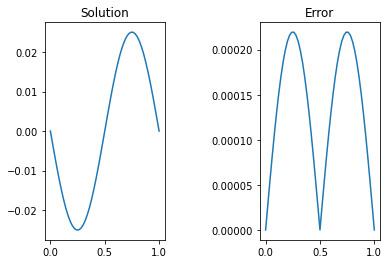

In [5]:
# Setting the grid space
n = 50
x = np.linspace(0,1,n+1)
h = x[1] - x[0]

# Initialize grid for iterative method
u0 = np.zeros(n+1)
k = h**2*np.sin(2*np.pi*x)

# Jacobi method
ujac = iterate(lambda u: (jac(u,k)),u0,1e3,1e-5)

# Plot and compare to the analytic solution
sol = -np.sin(2*np.pi*x)/4/np.pi**2;
fig,ax = plt.subplots(1,2)
ax[0].plot(x,ujac)
ax[0].set_title('Solution')
ax[1].plot(x,abs((ujac-sol)))
ax[1].set_title('Error')

# set the spacing between subplots
plt.subplots_adjust(wspace=0.8)
plt.show()

### Gauss-Seidel

To speed up convergence, the iterations can be applied
sequentially to each grid-point; for example by sweeping from left to right in the domain and updating each grid point in turn. This technique is known as the Gauss-Seidel
relaxation method.

Grid values are updated "in-place" as we sweep left to right, and the updated result at each point is fed into the subsequent calculation.

<br>

```{image} images/GS.gif
:alt: secant
:align: center
:scale: 65%
```
<br>

A code that implements this algorithm is provided below.

In [6]:
def gsl(u0,k):
    u1 = np.copy(u0)
    # Gauss-Seidel iteration
    for i in range(1,len(u1)-1):
        u1[i] = (u1[i-1]+u1[i+1]-k[i])/2
    return u1

In [7]:
# Gauss-Seidel
u0 = np.zeros(n+1) # re-initialize
ugsl = iterate(lambda u: gsl(u,k),u0,1e3,1e-5)

converged after 366 iterations


### Successive relaxation

A less obvious improvement in the technique, known as *sucessive relaxation*, starts with the observation that in each update step we obtain a relationship of the form

```{math}
u_{i,j}^{(new)}=u_{i,j}^{(old)}+r_{i,j}, \qquad u^{(new)}_{i,j}=F(u^{(old)})_{i,j}
```
where $r_{i,j}$ is the residual error. The proposal allows that faster convergence might be obtained by adjusting the update step in proportion to the size of the residual, which is supposed to converge to zero:

```{math}
:label: relax
u_{i,j}^{(new)}=u_{i,j}^{(old)}+\gamma r_{i,j}, \qquad r_{i,j}=F(u^{(old)})_{i,j} -u^{(old)}_{i,j}
```

The relaxation parameter $\gamma$ is selected for faster convergence, with

* $\gamma>1$ over-relaxation,
* $\gamma=1$ gives the ordinary GS method,
* $\gamma<1$ under-relaxation.

It is difficult to predict the optimum value of $\gamma$, but values in the range $(1,2)$ typically work well.

In [8]:
def rlx(u0,k,g):
    # Relaxation method using relaxation parameter g
    u1 = np.copy(u0)
    for i in range(1,len(u1)-1):
        u2 = (u1[i-1]+u1[i+1]-k[i])/2
        u1[i] = u1[i] + g*(u2-u1[i])
    return u1

# Relaxation
u0 = np.zeros(n+1) # re-initialize
sor=1.8818
ulrx = iterate(lambda u: rlx(u,k,sor),u0,1e3,1e-5)


converged after 86 iterations


```{admonition} Note
In this case (and some others) the optimum parameter for Successive Over-Relaxation (SOR) can be predicted from the coefficient matrix.
```

In [9]:
M = np.diag(np.hstack((1,-2*np.ones(n-1),1)),k=0) + \
    np.diag(np.hstack((np.ones(n-1),0)),     k=-1)+ \
    np.diag(np.hstack((0,np.ones(n-1))),  k=1)

C = np.eye(n+1)-np.linalg.lstsq(np.diag(np.diag(M)),M, rcond=None)[0]
m = np.max(np.abs(np.linalg.eig(C)[0]))
sor = 1+m**2/(1+np.sqrt(1-m**2))**2
print(sor)

1.8818383898322146


## Axially symmetric heat flow

The image below shows a cross-section of pipe insulation, which is subjected to temperatures $\phi=500K$ on the inner boundary and $\phi=300K$ on the outer boundary. The radial and axial directions are denoted by $r,\theta$, respectively.

<br>

```{image} images/lagging.png
:alt: secant
:align: center
:scale: 40%
```
<br>

Due to axial symmetry of the problem, the governing two-dimensional heat equation $\nabla^2\phi=0$ for this problem can be reduced to
```{math}
:label: heateqn
\frac{\partial^2\phi}{\partial r^2}+\frac{1}{r}\frac{\partial \phi}{\partial r}=0.
```

```{exercise}
Express equation {eq}`heateqn` in finite difference form, using a central difference scheme, and apply a Gauss-Seidel relaxation technique with 11 radial points to determine the solution $\phi(r)$ for $r\in[0.05,0.10]$ to within $10^{-4}$.

Graphically compare your answer to the analytic solution, which is given by
\begin{equation*}\phi = 200\frac{\ln(0.10)-\ln(r)}{\ln(2)} +300.\end{equation*}
```

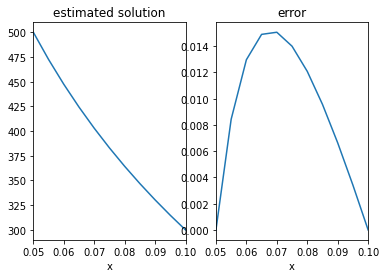

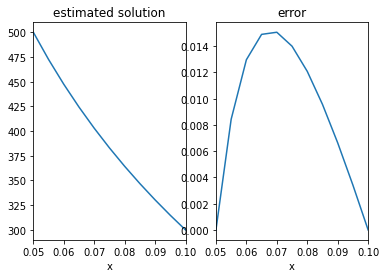

In [10]:
from myst_nb import glue
import numpy as np
import matplotlib.pyplot as plt

n=11;                          #We are using 11 points
r = np.linspace(0.05,0.10,n)   #Construct the radial coordinate
h =r[2]-r[1]                     

#Set up the initial grid :
F = 400*np.ones(n)   # The temperature average is a suitable choice
F[[0,-1]]=[500,300]  # Enforce boundary conditions

for j in range(200):         #Limit to 200 iterations
    Fcheck = np.copy(F)      #To check for convergence
    for k in range(1,n-1):   #On interior points
        F[k] = ((r[k]-h/2)*F[k-1]+(r[k]+h/2)*F[k+1])/2/r[k];
    if np.linalg.norm(Fcheck-F)<10^-4:
        print('converged after',j, 'iterations')
        break

# Plot and compare to the analytic solution

a=-200/np.log(2); b=500-200*np.log(20)/np.log(2);
Fanalytic= a*np.log(r)+b;

fig,ax = plt.subplots(1,2)
ax[0].plot(r,F)
ax[0].set_title('estimated solution')
ax[1].plot(r,np.abs(F-Fanalytic))
ax[1].set_title('error')

ax[0].set_xlim([0.05,0.1])
ax[0].set_xlabel('x')
ax[1].set_xlim([0.05,0.1])
ax[1].set_xlabel('x')

glue("axisymm_fig", fig, display=False)

````{toggle}

**Solution**
The equation can be written out using the central differences formula as:

\begin{equation*}
\frac{\phi_{i-1}-2\phi_i+\phi_{i+1}}{h^2}+\frac{1}{r_i}\frac{\phi_{i+1}-\phi_{i-1}}{2h}=0
\end{equation*}

which rearranges to

\begin{equation*}
\phi_i=\frac{\left(r_i-\frac{h}{2}\right)\phi_{i-1}+\left(r_i+\frac{h}{2}\right)\phi_{i+1}}{2r_i}
\end{equation*}

This can be applied as follows

```python
import numpy as np
import matplotlib.pyplot as plt

n=11;                          #We are using 11 points
r = np.linspace(0.05,0.10,n)   #Construct the radial coordinate
h =r[2]-r[1]                     

#Set up the initial grid :
F = 400*np.ones(n)   # The temperature average is a suitable choice
F[[0,-1]]=[500,300]  # Enforce boundary conditions

for j in range(200):         #Limit to 200 iterations
    Fcheck = np.copy(F)      #To check for convergence
    for k in range(1,n-1):   #On interior points
        F[k] = ((r[k]-h/2)*F[k-1]+(r[k]+h/2)*F[k+1])/2/r[k];
    if np.linalg.norm(Fcheck-F)<10^-4:
        print('converged after',j, 'iterations')
        break
```

In this case we are able to compare to the analytic solution obtained by integrating the ODE by hand:

```python
# Plot and compare to the analytic solution

a=-200/np.log(2); b=500-200*np.log(20)/np.log(2);
Fanalytic= a*np.log(r)+b;

fig,ax = plt.subplots(1,2)
ax[0].plot(r,F)
ax[0].set_title('estimated solution')
ax[1].plot(r,np.abs(F-Fanalytic))
ax[1].set_title('error')

ax[0].set_xlim([0.05,0.1])
ax[0].set_xlabel('x')
ax[1].set_xlim([0.05,0.1])
ax[1].set_xlabel('x')

plt.show()
```

```{glue:} axisymm_fig
```

````